In [1]:
import pandas as pd
pd.options.display.max_columns=50
from scipy import stats as st
import numpy as np


import matplotlib.pyplot as plt
import json
from matplotlib import gridspec
from matplotlib import cm
import seaborn as sns
import re

In [2]:
coding= pd.read_csv("../data/coding_results_resistance.tsv.gz",sep="\t")
coding["significant"] =coding.apply(lambda r: r["qvalue"] <0.05 and r["log_odds_ratio"]>0,axis=1)
non_coding= pd.read_csv("../data/non_coding_results_resistance.tsv.gz",sep="\t")
non_coding["significant"] = coding.apply(lambda r: r["qvalue"] <0.1 and r["log_odds_ratio"]>0,axis=1)
cnv = pd.read_csv("../data/cnv_results_resistance.tsv.gz",sep="\t")
cnv["significant"] = cnv.apply(lambda r: r["qvalue"] <0.05 and r["not_gene"]==False  and r["log_odds_ratio"]>0,axis=1)
total = pd.concat([coding,non_coding,cnv])
total["label_spaces"] = total.apply(lambda row: row["label"].replace("_"," "),axis=1)

In [3]:
total = pd.read_csv("../results/data/table_all_TEDS.tsv",sep="\t")

### Aux

In [4]:
def concat(grp):
    return ",".join(list(set(grp)))
    

### Example, plot

In [5]:
s=total[(total["is_TED"])&(total["is_subtype"]==False)]
d_total={}
for drug,ttype in s[["drug","cancer_type_code"]].drop_duplicates().values.tolist():
    with open(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/dndscv/{ttype}/{drug}.json") as f:
        d_total[(drug,ttype)]=json.load(f)

### Get untreated

In [6]:
d_untreated={}
for ttype in s["cancer_type_code"].unique():
    with open(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/dndscv/{ttype}/untreated.json") as f:
        d_untreated[ttype]=json.load(f)

### Coding mutations

In [7]:
extract_samples = s[s["type_alt"]=="coding mutations"][["drug","cancer_type_code","gene"]]
dict_coding={}
for drug,ttype in extract_samples[["drug","cancer_type_code"]].drop_duplicates().values.tolist():
    genes = list(extract_samples[(extract_samples["drug"]==drug)&(extract_samples["cancer_type_code"]==ttype)]["gene"].unique())
    df = pd.read_csv(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/dndscv/{ttype}/{drug}.dndscv.annotmuts.tsv.gz",sep="\t")
    dict_coding[(drug,ttype)]=df[(df["gene"].isin(genes))&(df["impact"]!="Synonymous")].groupby("gene").agg({"sampleID":concat}).to_dict()["sampleID"]
    

### Non-coding

In [8]:
extract_samples = s[s["type_alt"]=="non-coding mutation"][["drug","cancer_type_code","gene","genomic_element"]]
dict_noncoding={}
df=pd.read_csv("/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/analysis/dna-rep-ann/final-update/r-objects/non-coding-drivers/version-202211/mutation-info-retrieve/20221123-request/treatment-enriched-elements-full-info.tsv",sep="\t")
for drug,ttype in extract_samples[["drug","cancer_type_code"]].drop_duplicates().values.tolist():
    dict_noncoding[(drug,ttype)]={}
    pairs = extract_samples[(extract_samples["drug"]==drug)&(extract_samples["cancer_type_code"]==ttype)][["gene","genomic_element"]].values.tolist()
    for g,e in pairs:
        dict_noncoding[(drug,ttype)][(g,e)] = list(df[(df["cancer_type_code"]==ttype)&(df["treatment"]==drug)&(df["element_id"]==g)&(df["genomic_element"]==e)]["patient_id"].values)
    

### CNV - Amp

In [9]:
extract_samples = s[s["type_alt"]=="Amp"][["drug","cancer_type_code","gene"]]
dict_amp={}
for drug,ttype in extract_samples[["drug","cancer_type_code"]].drop_duplicates().values.tolist():
    dict_amp[(drug,ttype)]={}
    genes = list(extract_samples[(extract_samples["drug"]==drug)&(extract_samples["cancer_type_code"]==ttype)]["gene"].unique())
    df = pd.read_csv(f"~/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/GISTIC_rebuttal/Drivers_per_sample/ploidy_plus_2.5/Driver_per_sample_qvalue05_NOV2022/Drivers_per_sample_GISTIC_{ttype}_{drug}.txt",sep="\t")
    for gene in genes:
        dict_amp[(drug,ttype)][gene]=list(df[df[gene].str.contains("AMP")]["sampleId"].values)
    

### CNV - Del

In [10]:
extract_samples = s[s["type_alt"]=="Del"][["drug","cancer_type_code","gene"]]
dict_del={}
for drug,ttype in extract_samples[["drug","cancer_type_code"]].drop_duplicates().values.tolist():
    dict_del[(drug,ttype)]={}
    genes = list(extract_samples[(extract_samples["drug"]==drug)&(extract_samples["cancer_type_code"]==ttype)]["gene"].unique())
    df = pd.read_csv(f"~/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/GISTIC_rebuttal/Drivers_per_sample/ploidy_plus_2.5/Driver_per_sample_qvalue05_NOV2022/Drivers_per_sample_GISTIC_{ttype}_{drug}.txt",sep="\t")
    for gene in genes:
        dict_del[(drug,ttype)][gene]=list(df[df[gene].str.contains("DEL")]["sampleId"].values)
    

### For each treatment plot it!


In [11]:
d_summary={}
for d,t in d_total:
    l=[]
    samples=d_total[(d,t)]
    # coding
    if (d,t) in dict_coding:
        for g in dict_coding[(d,t)]:
            list_mutated=dict_coding[(d,t)][g].split(",")
            s_coding=[s in list_mutated for s in samples ]
            l.append([d,t,g,"coding mutations"]+s_coding)
    # non-coding
    if (d,t) in dict_noncoding:
        for g,e in dict_noncoding[(d,t)].keys():
            list_mutated=dict_noncoding[(d,t)][(g,e)]
            s_noncoding=[s in list_mutated for s in samples ]
            l.append([d,t,g,"non-coding mutation"]+s_noncoding)
    # amp
    if (d,t) in dict_amp:
        for g in dict_amp[(d,t)].keys():
            list_mutated=dict_amp[(d,t)][g]
            s_amp=[s in list_mutated for s in samples ]
            l.append([d,t,g,"Amp"]+s_amp)
    # del
    if (d,t) in dict_del:
        for g in dict_del[(d,t)].keys():
            list_mutated=dict_del[(d,t)][g]
            s_amp=[s in list_mutated for s in samples ]
            l.append([d,t,g,"Del"]+s_amp)
    tmp=pd.DataFrame(l,columns=["drug","cancer_type_code","gene","type_alt"]+samples)
    new_order=list(tmp[samples].sum(axis=0).sort_values(ascending=False).index)
    d_summary[(d,t)]=tmp[["drug","cancer_type_code","gene","type_alt"]+new_order]

### Annotate patients with treatment information

In [12]:
total_samples_with_treatment_info = pd.read_csv("/home/fran/Documents/cuppen/HPC/tunnel/cuppen/shared_resources/HMF_data/DR-104-update5/pre_biopsy_drugs.tsv",sep="\t")["patientIdentifier"].unique()
df_meta = pd.read_csv("../../data/SuppTable1_sample_metadata - metadata.tsv",sep="\t")
df_meta=df_meta[(df_meta["is_blacklisted"]==False)&(df_meta["cohort"]=="Hartwig")]

# Match sample ID with patient treatment
def get_patient_identifier(row):
    return re.search("([A-Z]+[0-9]+)[TI]+",row["sample_id"]).group(1)
df_meta["patientIdentifier"] = df_meta.apply(lambda row: get_patient_identifier(row),axis=1)
samples_with_info=set(df_meta[(df_meta["patientIdentifier"].isin(total_samples_with_treatment_info))]["sample_id"].values)

### Create a matrix with total number of patients with treatment information

In [13]:
l=[]
samples_tr,samples_t=set(),set()
for d,t in d_summary:
    v_=d_summary[(d,t)]
    samples_tr=samples_tr.union(set(d_total[(d,t)]))
    l.append(v_)
df_h = pd.concat(l).fillna(False)
df_h=df_h.merge(total[["drug","cancer_type_code","type_alt","label","annotated","gene"]])
df_h.head()
    

,drug,cancer_type_code,gene,type_alt,CPCT02070055TII,CPCT02150052T,CPCT02070433T,CPCT02290038T,CPCT02020275T,CPCT02010998T,CPCT02070444TII,CPCT02290006T,CPCT02070193T,CPCT02080078TII,CPCT02010585T,CPCT02140025T,CPCT02290031T,CPCT02070483T,CPCT02070426T,CPCT02020387T,CPCT02070307TII,CPCT02070367T,CPCT02140038T,CPCT02010857T,CPCT02070235T,...,CPCT02050089T,CPCT02330139T,CPCT02050239T,CPCT02380033T,CPCT02210068T,CPCT02050070T,CPCT02110060T,CPCT02230035T,CPCT02030262T,CPCT02060108T,CPCT02120123T,CPCT02110091T,CPCT02130044T,CPCT02120131T,CPCT02050244T,CPCT02050246T,CPCT02220061T,CPCT02110088T,CPCT02210054T,CPCT02020946T,CPCT02020693T,CPCT02010351T,CPCT02030521T,label,annotated
0,Anti_AR__GnRH,PRAD,AR,coding mutations,True,True,False,True,False,True,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,AR - Anti AR GnRH (PRAD),True
1,Anti_AR__GnRH,PRAD,ERF,coding mutations,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,ERF - Anti AR GnRH (PRAD),False
2,Anti_AR__GnRH,PRAD,RB1,coding mutations,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,RB1 - Anti AR GnRH (PRAD),False
3,Anti_AR__GnRH,PRAD,TP53,coding mutations,True,True,True,True,True,False,True,True,True,False,True,True,False,True,True,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,TP53 - Anti AR GnRH (PRAD),False
4,Anti_AR__GnRH,PRAD,ENSG00000141510_TP53,non-coding mutation,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,TP53 [splice sites] - Anti AR GnRH (PRAD),False


### Fraction of samples with TEDs (of the total with treatment information) (Fig. 6f)

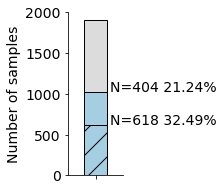

In [14]:

g=df_h[list(samples_tr)+["annotated"]].melt(id_vars="annotated",value_vars=samples_tr)
samples_an = set(g[(g["annotated"]==True)&(g["value"]==True)]["variable"].unique())
samples_nan = len(g[(g["annotated"]==False)&(g["value"]==True)&(~g["variable"].isin(samples_an))]["variable"].unique())
fig,ax = plt.subplots(figsize=(1,3))
ax.bar(x=0,height=len(samples_with_info),color="#DCDCDC",edgecolor="black")
ax.bar(x=0,height=len(samples_an),color="#a6cee3",hatch="/",edgecolor="black")
ax.bar(x=0,height=samples_nan,bottom=len(samples_an),color="#a6cee3",edgecolor="black")

ax.annotate(xy=(0.5,len(samples_an)),s=f"N={len(samples_an)} {format(len(samples_an)*100/len(samples_with_info),'.2f')}%",fontsize=14)
ax.annotate(xy=(0.5,samples_nan+len(samples_an)),s=f"N={samples_nan} {format(samples_nan*100/len(samples_with_info),'.2f')}%",fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xticks([0])
ax.set_xticklabels([""])
ax.set_xlim(-1.,1.)

ax.set_yticks(list(range(0,2500,500)))
ax.set_ylabel("Number of samples",fontsize=14)

plt.savefig(f'../results/figures/fraction_patients_with_TEDs.pdf', dpi=800,bbox_inches="tight")

In [15]:
1015 / len(samples_with_info)

0.5336487907465826

In [16]:
404 + 618

1022

### Load drivers per sample

In [19]:
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/linx_driver/misc/2022_11_23_total_dps_res.tsv ../data/

In [17]:
df_drivers = pd.read_csv("../data/2022_11_23_total_dps_res.tsv",sep="\t")
df_meta = pd.read_csv("../../data/SuppTable1_sample_metadata - metadata.tsv",sep="\t")
df_meta = df_meta[df_meta["is_blacklisted"]==False]
df_info = pd.read_csv("../results/data/list_drivers_resistance.tsv",sep="\t")
ttypes_with_res = list(df_info["cancer_type_code"].unique())
df_drivers_pcawg = df_drivers.merge(df_meta[df_meta["cohort"]=="PCAWG"][["sample_id","cohort","cancer_type","cancer_type_code"]].drop_duplicates())
df_drivers_hmf = df_drivers.merge(df_meta[df_meta["cohort"]=="Hartwig"][["sample_id","cohort","cancer_type","cancer_type_code"]].drop_duplicates())

##### Aux

In [18]:
def percentile_95(grp):
    return np.percentile(grp,95)
def percentile_5(grp):
    return np.percentile(grp,5)

In [19]:
df_sel = df_drivers_hmf[df_drivers_hmf["cancer_type_code"].isin(ttypes_with_res)]
df_sel_pcawg = df_drivers_pcawg[df_drivers_pcawg["cancer_type_code"].isin(ttypes_with_res)]
summary=df_sel.groupby("cancer_type_code").agg(no_res_mean=("no_res",np.nanmean),raw_mean=("with_res",np.nanmean),no_res_95=("no_res",percentile_95),no_res_5=("no_res",percentile_5),with_res_95=("with_res",percentile_95),with_res_5=("with_res",percentile_5),with_res_st=("with_res",np.nanstd),no_res_st=("no_res",np.nanstd))
summary_pcawg=df_sel_pcawg.groupby("cancer_type_code").agg(no_res_mean=("no_res",np.nanmean),raw_mean=("with_res",np.nanmean),no_res_95=("no_res",percentile_95),no_res_5=("no_res",percentile_5),with_res_95=("with_res",percentile_95),with_res_5=("with_res",percentile_5),with_res_st=("with_res",np.nanstd),no_res_st=("no_res",np.nanstd))
df_drivers=df_drivers.merge(df_meta[["sample_id","cohort"]])
summary_pan = df_drivers.groupby("cohort").agg(no_res_mean=("no_res",np.nanmean),raw_mean=("with_res",np.nanmean),no_res_95=("no_res",percentile_95),no_res_5=("no_res",percentile_5),with_res_95=("with_res",percentile_95),with_res_5=("with_res",percentile_5),with_res_st=("with_res",np.nanstd),no_res_st=("no_res",np.nanstd))
summary_pan

,no_res_mean,raw_mean,no_res_95,no_res_5,with_res_95,with_res_5,with_res_st,no_res_st
cohort,,,,,,,,
Hartwig,4.949580,5.687337,10,1,11,2,2.870017,2.861905
PCAWG,3.975967,4.140021,9,0,9,1,2.694448,2.678143


In [20]:
summary_pcawg

,no_res_mean,raw_mean,no_res_95,no_res_5,with_res_95,with_res_5,with_res_st,no_res_st
cancer_type_code,,,,,,,,
BRCA,4.517413,5.164179,10.0,0.0,11.00,1.00,2.981260,3.026705
COREAD,5.647059,6.274510,12.5,2.0,13.00,2.00,3.429743,3.531705
KIRC,2.201835,2.229358,4.0,1.0,4.00,1.00,1.151754,1.128583
LUAD,3.472222,4.027778,6.0,1.0,6.25,1.75,1.949155,1.812435
LUSC,6.595745,6.595745,11.0,3.0,11.00,3.00,2.609844,2.609844
OV,3.700000,3.709091,7.0,1.0,7.00,1.00,2.069195,2.074529
PAAD,4.967890,4.967890,8.0,3.0,8.00,3.00,1.596042,1.596042
PRAD,2.045752,2.379085,5.4,0.0,6.00,0.00,1.622241,1.474966
SKCM,3.971154,4.461538,8.0,1.0,8.00,2.00,1.970280,2.083018


In [21]:
np.nanmean(summary["no_res_mean"])

4.918720872147879

In [22]:
np.nanmean(summary_pcawg["raw_mean"])

4.5681900684126955

In [23]:
summary["raw_mean"]  - summary["no_res_mean"]

cancer_type_code
BRCA      1.119845
COREAD    0.772947
KIRC      0.300000
LUAD      1.047059
LUSC      0.000000
OV        0.096154
PAAD      0.000000
PRAD      1.740000
SKCM      0.511551
STAD      0.837209
dtype: float64

###  Remove TEDs from number of drivers per sample, compared to primary (Fig. 6g)

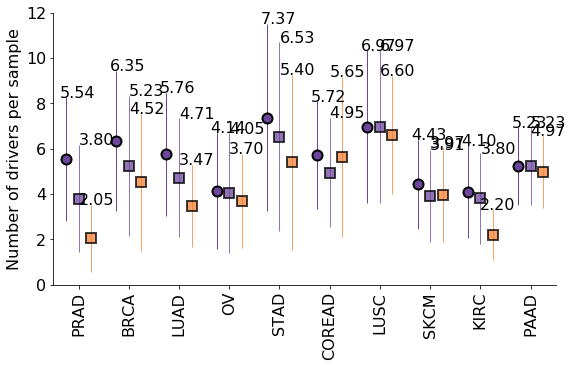

In [30]:
df_sel = df_drivers_hmf[df_drivers_hmf["cancer_type_code"].isin(ttypes_with_res)]

fig, ax = plt.subplots(figsize=(9,5))

xt=[]
xs=range(0,len(ttypes_with_res)*4,4)
for j,ttype in enumerate(ttypes_with_res):
    i=xs[j]
    y=summary.loc[ttype]["raw_mean"]
    ci_95 = summary.loc[ttype]["with_res_95"] - y
    ci_5 = y- summary.loc[ttype]["with_res_5"]
    st=summary.loc[ttype]["with_res_st"]
    ax.errorbar(x=i-1.0,y=y,yerr=st,fmt="o",markersize=10,color="#6B469A",elinewidth=1.0,markeredgewidth=2.0,markeredgecolor="black")
    ax.annotate(xy=(i-1.5,st+y),s="%.2f" % (y) ,fontsize=16)
    
    y=summary.loc[ttype]["no_res_mean"]
    ci_95 = float(summary.loc[ttype]["no_res_95"]) - y
    ci_5 = y - float(summary.loc[ttype]["no_res_5"])
    st=summary.loc[ttype]["no_res_st"]
    ax.errorbar(x=i+0.0,y=y,yerr=st,fmt="s",markersize=10,color="#6B469A",elinewidth=1.0,markeredgewidth=2.0,markeredgecolor="black",alpha=0.75)
    ax.annotate(xy=(i,st+y),s="%.2f" % (y) ,fontsize=16)
    
    y=summary_pcawg.loc[ttype]["no_res_mean"]
    ci_95 = float(summary_pcawg.loc[ttype]["no_res_95"]) - y
    ci_5 = y - float(summary_pcawg.loc[ttype]["no_res_5"])
    st=summary_pcawg.loc[ttype]["no_res_st"]
    ax.errorbar(x=i+1.0,y=y,yerr=st,fmt="s",markersize=10,color="#F58134",elinewidth=1.0,markeredgewidth=2.0,markeredgecolor="black",alpha=0.75)
    ax.annotate(xy=(i,st+y),s="%.2f" % (y) ,fontsize=16)
    
    xt.append(i)
    
ax.set_xticks(xt)
    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("Number of drivers per sample",fontsize=16)

ax.set_xticklabels([df_drivers_hmf[df_drivers_hmf["cancer_type_code"]==x]["cancer_type_code"].values[0] for x in ttypes_with_res],rotation=90)
ax.set_ylim(0,12)
ax.set_xlim(-2,38)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'../results/figures/drivers_per_sample_split_by_treatment_full.pdf', dpi=800,bbox_inches="tight")

### Fraction of drivers per sample increase explained  by TEDs

In [34]:
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/linx_driver/misc/2022_11_25_resistance_mean_dps.tsv ../data/

In [16]:
df_m = pd.read_csv("../data/2022_11_25_resistance_mean_dps.tsv",sep="\t")
df_meta = pd.read_csv("../../data/SuppTable1_sample_metadata - metadata.tsv",sep="\t")
df_meta = df_meta[df_meta["is_blacklisted"]==False]

In [18]:
df_m[(df_m["cohort"]=="Hartwig")|((df_m["cohort"]=="PCAWG")&(df_m["group"]=="+res"))].merge(df_meta[["cancer_type_code","cancer_type"]].drop_duplicates()).to_csv("../results/data/mean_drivers_per_sample.tsv",sep="\t")

In [42]:
df_m.groupby(["cohort","group"]).agg({"mean_dps":np.nanmean})

mean_dps
cohort  group          
Hartwig +res   5.308653
        -res   5.010215
PCAWG   +res   4.479695
        -res   4.341074

### Difference in number of drivers per sample after substrating TEDSs

In [38]:
(5.3 - 5.0)  

0.2999999999999998

### Total difference of raw hartwig, compared to raw PCAWG

In [39]:
(5.3 - 4.47)  

0.8300000000000001

### Fraction of difference explained by TEDs

In [40]:
0.3/0.8300000000000001

0.36144578313253006